# HAND CRAFTED MODEL

__`Group Number:`__ 

**10**

__`Group Members`__ 

|STUDENT NUMBER|STUDENT NAME|EMAIL|
|---|---|---|
|Ianis Rușitoru|20220620|20220620@novaims.unl.pt|
|Ricardo Almeida|20220584|20220584@novaims.unl.pt|
|Nichita Zamisnii|20220617|20220617@novaims.unl.pt|
|Pedro Paris|20191217|20191217@novaims.unl.pt|


__`Links`__   

[Github Data Source](https://github.com/garythung/trashnet)

[Google Drive Project Folder](https://drive.google.com/drive/folders/1KfXat-zOA1sJ-0m4-4yhEesj48KawVAj)

__`Summary`__ 

-Step 1:  Import of neccesary libraries

-Step 2:  Defining the conections and unziping the data

-Step 3:  Definition of the functions that will be used

-Step 4/5:  Spliting the data in training and validation data

-Step 6:  Defining usefull functions that will be used further int the notebook

-Step 7:  Creation of the model and its improvement throgh several iterations

__`Findings`__

- Augmentation is needed in order to train this model since we have a small dataset and overfitting issues.
- Batch normalization was needed to normalize input data, increase model stability and reduce overfitting and imrpove generalization
- Model depth often comes along with overfitting issues as a result we have used dropout layers to overcome it
- The starting model had a test accuracy of 50% and after 6 itterations we achieved 80%

## Data Import

__`Step 1`__ Import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import datasets
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

__`Step 2`__ Define the connection strings

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/Group10_Deep_Learning/"
main_folder, training_folder, testing_folder = "reduced_data/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'reduced_dataset.zip', 'reduced_dataset.zip')
    # Extract files
    zip_ = zipfile.ZipFile('reduced_dataset.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""


Mounted at /content/drive
File transfer completed in 1.389 seconds


__`Step 3`__ Define a list of parameters for the ``image_dataset_from_directory``.

In [ ]:
image_size=(256, 256)
color_mode='rgb'
batch_size=32
label_mode="categorical"
validation_split=0.15
shuffle=True
seed=0
crop_to_aspect_ratio=True
input_shape = (*image_size, 3)

__`Step 4`__ We have loaded the training data using ``image_dataset_from_directory`` assigning 15% of the training data as validation 

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)

Found 2028 files belonging to 5 classes.
Using 1724 files for training.
Using 304 files for validation.


__`Step 5`__ We have loaded test datasest which represents 15% of our total images `Inline code`

In [ ]:
ds_test = image_dataset_from_directory(path + main_folder + testing_folder,
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 362 files belonging to 5 classes.


__`Step 6`__ Define useful functions for plotting, testing and a callback to get the best weights of every model after training

In [ ]:
# Plot learning curves & loss

def learning_curve(model_history):
    df_hist = pd.DataFrame.from_dict(model_history.history)
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
    secondary_y = ["accuracy", "val_accuracy"]
    ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                      secondary_y = secondary_y,
                      kind="line", figsize=(6, 3), grid=True, legend=True,
                      ylabel="Categorical cross-entropy", 
                      xlabel="Epoch", title="Learning curves",                  
                      color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
    ax.right_ax.set_ylabel("Accuracy")
    ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
    ax.legend(loc=(0, -0.45), framealpha=1.0)
    plt.show()

In [ ]:
# Evaluate the model on the test data
def assesment(model,test_data):

    results = model.evaluate(test_data)

    # Print the test loss and accuracy
    print(f"Test loss: {results[0]:.4f}")
    print(f"Test accuracy: {results[1]:.4f}")

def compare_models(model1, model2, test_data):
  results1 = model1.evaluate(test_data)
  results2 = model2.evaluate(test_data)
    
  print("Current Baseline Model")
  print(f"Test loss: {results1[0]:.4f}")
  print(f"Test accuracy: {results1[1]:.4f}")
    
  print("Candidate Model")
  print(f"Test loss: {results2[0]:.4f}")
  print(f"Test accuracy: {results2[1]:.4f}")


This is used to load the best weights obtained during training into that mode. <br>  The weights that achieved the minimum validation loss are used

In [ ]:
def get_checkpoint_callback(model_name):
    # Define the checkpoint filepath
    checkpoint_filepath = f'best_weights_{model_name}.h5'

    # Create the ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    return checkpoint_callback, checkpoint_filepath

This is used to do side-by-side comparison of the plots

In [ ]:
def learning_curves(baseline_history, candidate_history):
    df_baseline = pd.DataFrame.from_dict(baseline_history.history)
    df_baseline["Epoch"] = np.arange(1, len(df_baseline) + 1, 1)
    df_candidate = pd.DataFrame.from_dict(candidate_history.history)
    df_candidate["Epoch"] = np.arange(1, len(df_candidate) + 1, 1)

    # Find the maximum accuracy value from both dataframes
    max_accuracy = max(df_baseline['accuracy'].max()+0.1, df_baseline['val_accuracy'].max()+0.1, 
                       df_candidate['accuracy'].max()+0.1, df_candidate['val_accuracy'].max()+0.1)

    # Plot baseline model
    fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
    secondary_y = ["accuracy", "val_accuracy"]
    ax = df_baseline.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                      secondary_y=secondary_y,
                      kind="line", ax=axs[0], grid=True,
                      ylabel="Categorical cross-entropy",
                      xlabel="Epoch", title="Current Baseline Model",
                      color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10, legend=None)
    ax.right_ax.set_ylabel("Accuracy")
    ax.right_ax.set_ylim([0, max_accuracy])  # Set the limit for the right y-axis

    # Plot candidate model
    ax = df_candidate.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                      secondary_y=secondary_y,
                      kind="line", ax=axs[1], grid=True,
                      ylabel="Categorical cross-entropy",
                      xlabel="Epoch", title="Candidate Model",
                      color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10, legend=None)
    ax.right_ax.set_ylabel("Accuracy")
    ax.right_ax.set_ylim([0, max_accuracy])  # Set the limit for the right y-axis

    fig.subplots_adjust(wspace=0.3) # Increase horizontal space between subplots

    # Add a single legend outside the plot area
    lines = [axs[0].lines[0], axs[0].lines[1], axs[0].right_ax.lines[0], axs[0].right_ax.lines[1]]
    labels = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False)

    plt.show()


## Model building using greedy procedure

#### Evaluation:
 - Every model will be trained for 100 epochs
 - To ensure a fair comparison every model will use the same optimizer: Adam with learning rate of 0.0001 
 - Assesment will be done on the following criteria:
  - Accuracy score on validation & test
  - Loss
  - Degree of overfitting
  - Smoothness of the learning curve

#### CNN1

__`Step 7`__ In the following cell we defined the basline model **cnn1** with the following characteristics: <br>
- 2 Hidden Layers <br>
- A number of 32 Kernels in the first layer and 64 in the second, Kernel Size = 3x3 <br>
- Max Pooling 2x2 and ReLu activation function for the hidden layers <br>
- After the hidden layers we perform dimensionality reduction with Flatten 
- There is no activation function specified in the output layer because the loss function used is CategoricalCrossentropy with the parameter from_logits set to True. This means that the model will output logits (raw predictions) instead of probabilities, and the loss function will apply a softmax activation internally before computing the loss. Therefore, the final Dense layer doesn't need an activation function explicitly specified, and it can output the logits directly. It is used to avoid potential numerical stability issues that could arise if we applied the softmax activation directly to the output layer and used the cross-entropy loss function with its default settings.

In [ ]:
# Define the model architecture
cnn1 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(5)
])

# Compile the model
cnn1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 5)                 1

In [ ]:
callback1, filepath1 = get_checkpoint_callback('model1')
history1 = cnn1.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=[callback1])
cnn1.load_weights(filepath1)

Epoch 1/100
54/54 [==============================] - 17s 96ms/step - loss: 120.5806 - accuracy: 0.3173 - val_loss: 8.9651 - val_accuracy: 0.4737
Epoch 2/100
54/54 [==============================] - 4s 79ms/step - loss: 4.2817 - accuracy: 0.5835 - val_loss: 4.9691 - val_accuracy: 0.5329
Epoch 3/100
54/54 [==============================] - 4s 74ms/step - loss: 1.2244 - accuracy: 0.7593 - val_loss: 4.2038 - val_accuracy: 0.5197
Epoch 4/100
54/54 [==============================] - 3s 56ms/step - loss: 0.4405 - accuracy: 0.8846 - val_loss: 3.7069 - val_accuracy: 0.5526
Epoch 5/100
54/54 [==============================] - 4s 62ms/step - loss: 0.2097 - accuracy: 0.9327 - val_loss: 3.4534 - val_accuracy: 0.6020
Epoch 6/100
54/54 [==============================] - 4s 65ms/step - loss: 0.1348 - accuracy: 0.9629 - val_loss: 3.7790 - val_accuracy: 0.5789
Epoch 7/100
54/54 [==============================] - 4s 62ms/step - loss: 0.0613 - accuracy: 0.9809 - val_loss: 3.4512 - val_accuracy: 0.5888
Epo

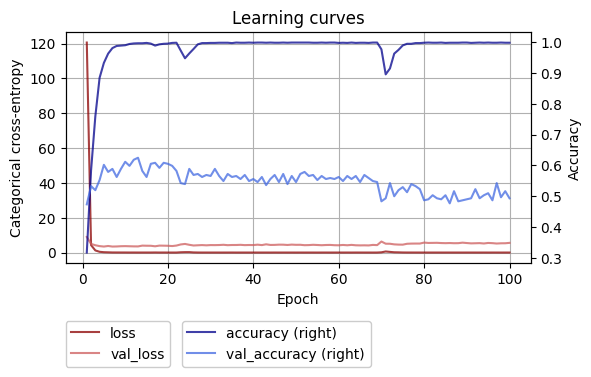

12/12 [==============================] - 1s 29ms/step - loss: 4.3159 - accuracy: 0.5110
Test loss: 4.3159
Test accuracy: 0.5110


In [ ]:
learning_curve(history1)
assesment(cnn1,ds_test)

__`Assesment 1`__ The model is severely overfitting. It reaches a train accuracy score of near 100% meanwhile the maxium validation socre is 57.89% with a rugged learning curve. Likewise it performs poorly on test with a accuracy score of 47.5%
 <br>Note the weights corresping to the lowest loss (epoch 99) were used to compute the test score.
<br> <br>
__`Proposed improvment`__ Introduce training data augmentation to:
- Reduce overfitting
- Boost performance

In [ ]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.15), 
                           layers.RandomZoom(height_factor=0.15, width_factor=0.1),
                           layers.RandomBrightness(factor=0.15),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")

In [ ]:
iter_train = iter(ds_train.as_numpy_iterator())

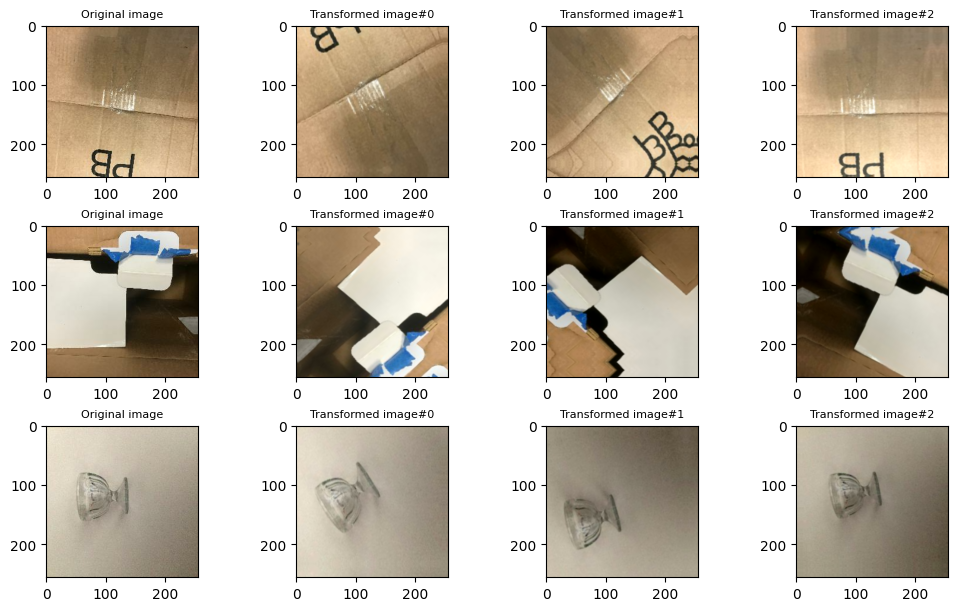

In [ ]:
batch_x_train, batch_y_train = iter_train.next()
def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=3, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation_pipe(img, training=True)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)

show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=augmentation)

#### CNN2

In [ ]:
cnn2 = models.Sequential([
    layers.Input(shape=input_shape),
    augmentation, # New
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(5)
])

cnn2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (256, 256, 3)            0         
 equential)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                      

In [ ]:
callback2, filepath2 = get_checkpoint_callback('model2')
history2 = cnn2.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=[callback2])
cnn2.load_weights(filepath2)

Epoch 1/100
54/54 [==============================] - 6s 80ms/step - loss: 149.3191 - accuracy: 0.2372 - val_loss: 12.1720 - val_accuracy: 0.4178
Epoch 2/100
54/54 [==============================] - 4s 65ms/step - loss: 6.6135 - accuracy: 0.4124 - val_loss: 6.0212 - val_accuracy: 0.4211
Epoch 3/100
54/54 [==============================] - 4s 64ms/step - loss: 4.3821 - accuracy: 0.3776 - val_loss: 3.6066 - val_accuracy: 0.4671
Epoch 4/100
54/54 [==============================] - 4s 75ms/step - loss: 3.7352 - accuracy: 0.4026 - val_loss: 4.9154 - val_accuracy: 0.4375
Epoch 5/100
54/54 [==============================] - 4s 68ms/step - loss: 2.5933 - accuracy: 0.4403 - val_loss: 2.5881 - val_accuracy: 0.4638
Epoch 6/100
54/54 [==============================] - 4s 66ms/step - loss: 2.5940 - accuracy: 0.4275 - val_loss: 4.4787 - val_accuracy: 0.3816
Epoch 7/100
54/54 [==============================] - 4s 64ms/step - loss: 2.4341 - accuracy: 0.4495 - val_loss: 3.3871 - val_accuracy: 0.3882
Epo

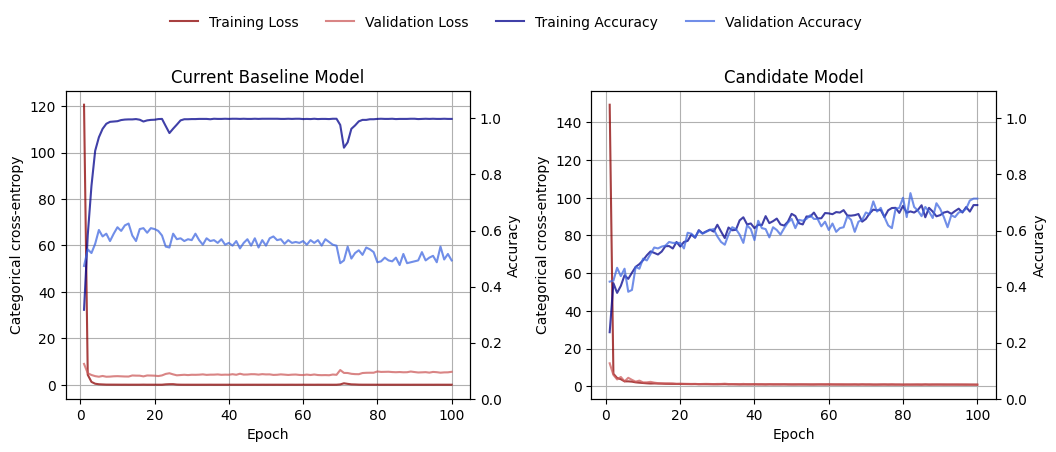

12/12 [==============================] - 1s 26ms/step - loss: 0.9949 - accuracy: 0.6657
Current Baseline Model
Test loss: 4.3159
Test accuracy: 0.5110
Candidate Model
Test loss: 0.9949
Test accuracy: 0.6657


In [ ]:
learning_curves(history1,history2)
compare_models(cnn1, cnn2, ds_test)

__`Assesment 2`__ The model is performing better. It reaches a maxium train accuracy score of 69.1% meanwhile the maxium validation score obtained is 71.4% with a rugged learning curve. Likewise it performs on test with a accuracy score of 66.5%.

__`Proposed improvment`__ By deepening the arhitecture we aim to improve the performance of the model. We thus propouse to introduce an additional convolutional layer with the following characteristics:
- 128 kernels with size 3x3
- ReLu activation function to introduce non-linearity to the output



#### CNN3

In [ ]:
cnn3 = models.Sequential([
    layers.Input(shape=input_shape),
    augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'), # New
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(5)
])

cnn3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
cnn3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (256, 256, 3)            0         
 equential)                                                      
                                                                 
 conv2d_7 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                      

In [ ]:
callback3, filepath3 = get_checkpoint_callback('model3')
history3 = cnn3.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=[callback3])
cnn3.load_weights(filepath3)

Epoch 1/100
54/54 [==============================] - 8s 80ms/step - loss: 31.3928 - accuracy: 0.3045 - val_loss: 5.2200 - val_accuracy: 0.4243
Epoch 2/100
54/54 [==============================] - 5s 85ms/step - loss: 2.8509 - accuracy: 0.3973 - val_loss: 2.3075 - val_accuracy: 0.4243
Epoch 3/100
54/54 [==============================] - 4s 76ms/step - loss: 2.0920 - accuracy: 0.4298 - val_loss: 2.1086 - val_accuracy: 0.4539
Epoch 4/100
54/54 [==============================] - 4s 76ms/step - loss: 1.7809 - accuracy: 0.4542 - val_loss: 1.6272 - val_accuracy: 0.4967
Epoch 5/100
54/54 [==============================] - 5s 84ms/step - loss: 1.6825 - accuracy: 0.4809 - val_loss: 1.9255 - val_accuracy: 0.4671
Epoch 6/100
54/54 [==============================] - 4s 76ms/step - loss: 1.4482 - accuracy: 0.5041 - val_loss: 1.4507 - val_accuracy: 0.5461
Epoch 7/100
54/54 [==============================] - 4s 77ms/step - loss: 1.3075 - accuracy: 0.5302 - val_loss: 1.2959 - val_accuracy: 0.5395
Epoch

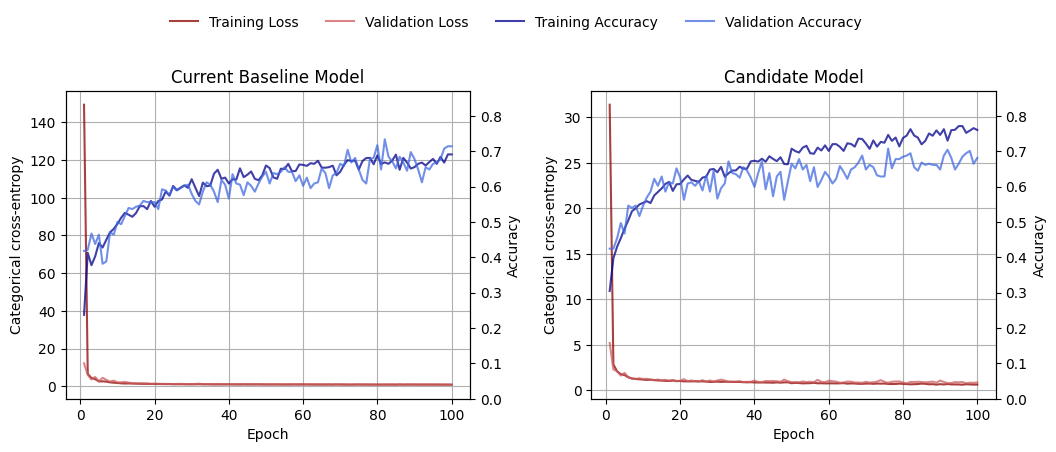

12/12 [==============================] - 1s 31ms/step - loss: 0.7901 - accuracy: 0.7099
Current Baseline Model
Test loss: 0.9949
Test accuracy: 0.6657
Candidate Model
Test loss: 0.7901
Test accuracy: 0.7099


In [ ]:
learning_curves(history2,history3)
compare_models(cnn2, cnn3, ds_test)

__`Assesment 3`__ The model is performed slightly better after increasing its depth. It reaches a maxium train accuracy score of 75.2% meanwhile the maxium validation score obtained is 70,7%, which is not a very big improvement. Also it performs a little better on test with a accuracy score of 70.1% and we see an improvement in the loss.

__`Proposed improvment`__ Introduce batch normalization to:
- Normalize input data
- Increase model stability
- Reduce overfitting and imrpove generalization



#### CNN4

In [ ]:
cnn4 = models.Sequential([
    layers.Input(shape=input_shape),
    augmentation,
    layers.BatchNormalization(), # New
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(5)
])


cnn4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (256, 256, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_10 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 64)      18496     
                                                      

In [ ]:
callback4, filepath4 = get_checkpoint_callback('model4')
history4 = cnn4.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=[callback4])
cnn4.load_weights(filepath4)

Epoch 1/100
54/54 [==============================] - 9s 89ms/step - loss: 1.4834 - accuracy: 0.3596 - val_loss: 2.1241 - val_accuracy: 0.3816
Epoch 2/100
54/54 [==============================] - 5s 91ms/step - loss: 1.2888 - accuracy: 0.4971 - val_loss: 1.5273 - val_accuracy: 0.4408
Epoch 3/100
54/54 [==============================] - 5s 84ms/step - loss: 1.2156 - accuracy: 0.5215 - val_loss: 1.5170 - val_accuracy: 0.4671
Epoch 4/100
54/54 [==============================] - 5s 84ms/step - loss: 1.2058 - accuracy: 0.5284 - val_loss: 1.3186 - val_accuracy: 0.5066
Epoch 5/100
54/54 [==============================] - 5s 91ms/step - loss: 1.1578 - accuracy: 0.5435 - val_loss: 1.0790 - val_accuracy: 0.5987
Epoch 6/100
54/54 [==============================] - 5s 84ms/step - loss: 1.1095 - accuracy: 0.5742 - val_loss: 1.0825 - val_accuracy: 0.6118
Epoch 7/100
54/54 [==============================] - 5s 91ms/step - loss: 1.0768 - accuracy: 0.5771 - val_loss: 1.0554 - val_accuracy: 0.6349
Epoch 

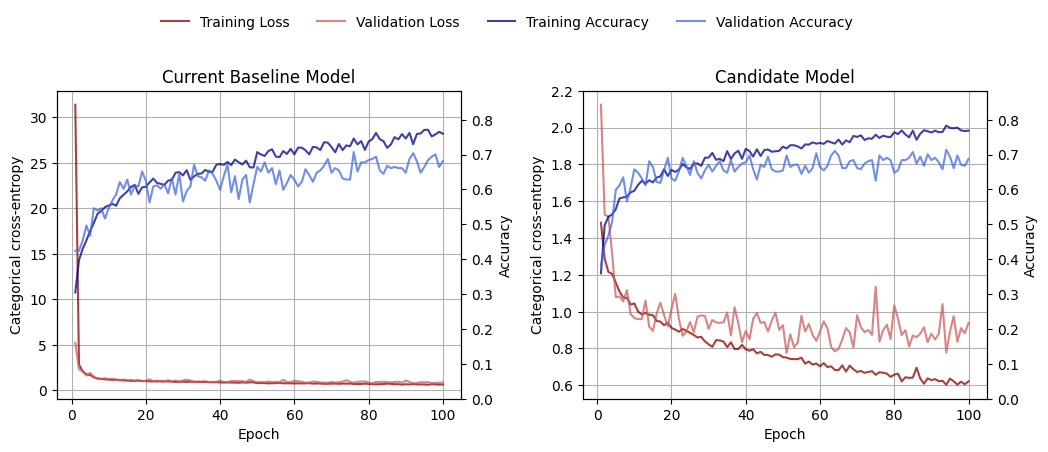

12/12 [==============================] - 1s 30ms/step - loss: 0.8661 - accuracy: 0.7155
Current Baseline Model
Test loss: 0.7901
Test accuracy: 0.7099
Candidate Model
Test loss: 0.8661
Test accuracy: 0.7155


In [ ]:
learning_curves(history3,history4)
compare_models(cnn3, cnn4, ds_test)

__`Assesment 4`__ After introducing BatchNormalization the model has shown improvement, with a maximum training accuracy score of 78.3% and a maximum validation score of 71.3%. The increase in performance is a positive development. Additionally, the model performed slightly better on the test dataset with an accuracy score of 71.5%. Becuase of the normalization the loss start at about 2.1 instead of 31 which will make the computation quicker

__`Proposed improvment`__ Introduce a fully connected layer and a dropout layer:
- Fully connected layer to increase the ability to capter more complex features learned in the previous layers
- Dropout layer to reduce overfitting

#### CNN5

In [ ]:
# 5 dense with dropout
cnn5 = models.Sequential([
    layers.Input(shape=input_shape),
    augmentation,
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'), # New
    layers.Dropout(.25), # New
    layers.Dense(5)
])

cnn5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn5.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (256, 256, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 125, 125, 64)      18496     
                                                      

In [ ]:
callback5, filepath5 = get_checkpoint_callback('model5')
history5 = cnn5.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=[callback5])
cnn5.load_weights(filepath5)

Epoch 1/100
54/54 [==============================] - 8s 100ms/step - loss: 1.4317 - accuracy: 0.4031 - val_loss: 1.9624 - val_accuracy: 0.4046
Epoch 2/100
54/54 [==============================] - 5s 93ms/step - loss: 1.2807 - accuracy: 0.4733 - val_loss: 1.7033 - val_accuracy: 0.4211
Epoch 3/100
54/54 [==============================] - 5s 90ms/step - loss: 1.1959 - accuracy: 0.5232 - val_loss: 1.3125 - val_accuracy: 0.5428
Epoch 4/100
54/54 [==============================] - 6s 102ms/step - loss: 1.1710 - accuracy: 0.5505 - val_loss: 1.1094 - val_accuracy: 0.5921
Epoch 5/100
54/54 [==============================] - 5s 88ms/step - loss: 1.1105 - accuracy: 0.5592 - val_loss: 1.1185 - val_accuracy: 0.5658
Epoch 6/100
54/54 [==============================] - 5s 92ms/step - loss: 1.0638 - accuracy: 0.5922 - val_loss: 1.0625 - val_accuracy: 0.6020
Epoch 7/100
54/54 [==============================] - 5s 90ms/step - loss: 1.0455 - accuracy: 0.6085 - val_loss: 1.0440 - val_accuracy: 0.6283
Epoc

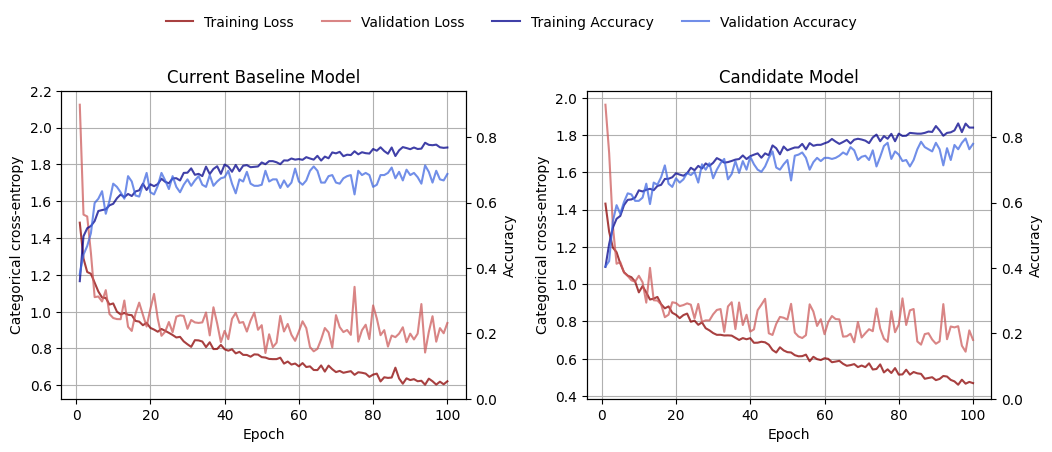

12/12 [==============================] - 1s 32ms/step - loss: 0.7527 - accuracy: 0.7680
Current Baseline Model
Test loss: 0.8661
Test accuracy: 0.7155
Candidate Model
Test loss: 0.7527
Test accuracy: 0.7680


In [ ]:
learning_curves(history4,history5)
compare_models(cnn4, cnn5, ds_test)

__`Assesment 5`__ The addition of a fully connected layer and a dropout layer to the model resulted in an improvement in its performance. The model achieved a maximum training accuracy score of 84.16% and a maximum validation score of 79.6%, indicating positive progress. Furthermore, the model's performance on the test dataset improved slightly, with an accuracy score of 76.8%.

__`Proposed improvment`__ Introduce and aditional convolutional layer and one more dropout to:
- 256 filters to capture even wider range of features
- The second dropout layer to decrease overfiting as the convolutional layer with most filters tend to overfit. 




#### CNN6

In [ ]:
cnn6 = models.Sequential([
    layers.Input(shape=input_shape),
    augmentation, # Added in cnn2
    layers.BatchNormalization(), # Added in cnn4
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'), # Added in cnn3
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'), # New
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25), ## New
    layers.Flatten(),
    layers.Dense(128, activation='relu'), # Added in cnn5
    layers.Dropout(0.25), # Added in cnn5
    layers.Dense(5)
])

cnn6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (256, 256, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_2 (Batc  (None, 256, 256, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 64)      18496     
                                                      

In [ ]:
callback6, filepath6 = get_checkpoint_callback('model6')
history6 = cnn6.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=[callback6])
cnn6.load_weights(filepath6)

Epoch 1/100
54/54 [==============================] - 12s 157ms/step - loss: 1.4831 - accuracy: 0.3521 - val_loss: 1.7535 - val_accuracy: 0.3618
Epoch 2/100
54/54 [==============================] - 8s 146ms/step - loss: 1.3153 - accuracy: 0.4704 - val_loss: 1.6471 - val_accuracy: 0.4112
Epoch 3/100
54/54 [==============================] - 8s 151ms/step - loss: 1.2570 - accuracy: 0.5023 - val_loss: 1.5072 - val_accuracy: 0.4507
Epoch 4/100
54/54 [==============================] - 9s 155ms/step - loss: 1.1943 - accuracy: 0.5249 - val_loss: 1.2132 - val_accuracy: 0.5000
Epoch 5/100
54/54 [==============================] - 8s 146ms/step - loss: 1.1412 - accuracy: 0.5557 - val_loss: 1.1827 - val_accuracy: 0.5230
Epoch 6/100
54/54 [==============================] - 8s 151ms/step - loss: 1.1083 - accuracy: 0.5615 - val_loss: 0.9979 - val_accuracy: 0.5954
Epoch 7/100
54/54 [==============================] - 8s 153ms/step - loss: 1.0808 - accuracy: 0.5806 - val_loss: 1.0006 - val_accuracy: 0.611

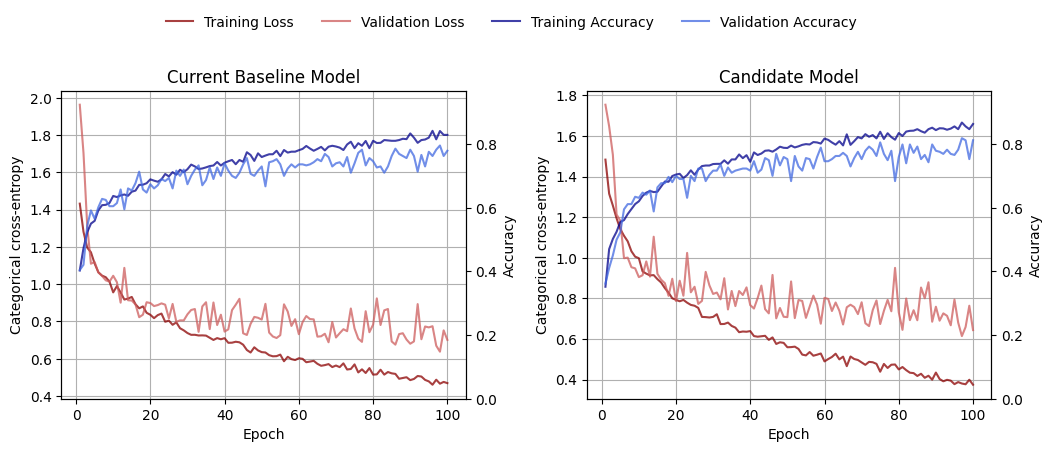

12/12 [==============================] - 1s 29ms/step - loss: 0.7105 - accuracy: 0.7707
Current Baseline Model
Test loss: 0.7527
Test accuracy: 0.7680
Candidate Model
Test loss: 0.7105
Test accuracy: 0.7707


In [ ]:
learning_curves(history5,history6)
compare_models(cnn5, cnn6, ds_test)

__`Assesment 6`__ The addition of a fully connected layer and a dropout layer to the model resulted in an improvement in its performance. The model achieved a maximum training accuracy score of 86.4% and a maximum validation score of 81.25%, indicating positive progress. Furthermore, the model's performance on the test dataset improved slightly, with an accuracy score of 77%.

__`Proposed improvment`__ Given the current depth of the neural network, we ought to try using the kernel sizes used in AlexNet, namely we increased the kernel size of firs two convolutional layers in order to:
- Capture global image features such as edges, corners and basic shapes with the 11x11 Kernel
- Capture more localized and higher-level features with the 5x5 and 3x3 Kernels


#### CNN7

In [ ]:
cnn7 = models.Sequential([
    layers.Input(shape=input_shape),
    augmentation,
    layers.BatchNormalization(),
    layers.Conv2D(32, (11, 11), activation='relu'), # New kernel size
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'), # New kernel size
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5)
])

cnn7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (256, 256, 3)            0         
 equential)                                                      
                                                                 
 batch_normalization_3 (Batc  (None, 256, 256, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_20 (Conv2D)          (None, 246, 246, 32)      11648     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 123, 123, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 119, 119, 64)      51264     
                                                      

In [ ]:
callback7, filepath7 = get_checkpoint_callback('model7')
history7 = cnn7.fit(ds_train, epochs=100, validation_data=ds_val, callbacks=[callback7])
cnn7.load_weights(filepath7)

Epoch 1/100
54/54 [==============================] - 21s 251ms/step - loss: 1.4725 - accuracy: 0.3498 - val_loss: 1.7187 - val_accuracy: 0.3849
Epoch 2/100
54/54 [==============================] - 10s 177ms/step - loss: 1.3312 - accuracy: 0.4530 - val_loss: 1.3499 - val_accuracy: 0.4638
Epoch 3/100
54/54 [==============================] - 10s 178ms/step - loss: 1.2899 - accuracy: 0.4681 - val_loss: 1.3756 - val_accuracy: 0.4638
Epoch 4/100
54/54 [==============================] - 10s 179ms/step - loss: 1.2624 - accuracy: 0.4994 - val_loss: 1.2956 - val_accuracy: 0.4605
Epoch 5/100
54/54 [==============================] - 10s 175ms/step - loss: 1.2116 - accuracy: 0.5133 - val_loss: 1.1855 - val_accuracy: 0.5428
Epoch 6/100
54/54 [==============================] - 10s 179ms/step - loss: 1.1797 - accuracy: 0.5302 - val_loss: 1.1006 - val_accuracy: 0.5526
Epoch 7/100
54/54 [==============================] - 10s 176ms/step - loss: 1.1279 - accuracy: 0.5661 - val_loss: 1.1470 - val_accuracy:

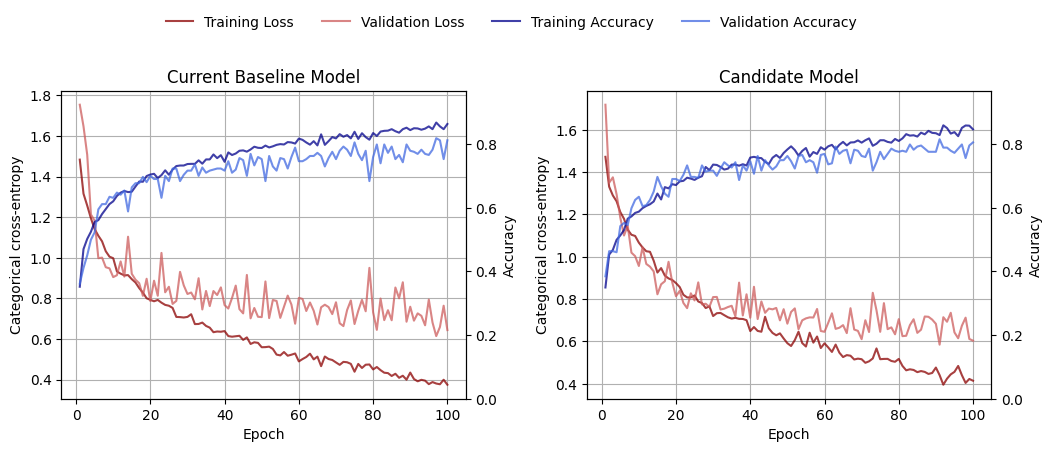

12/12 [==============================] - 1s 46ms/step - loss: 0.6693 - accuracy: 0.7956
Current Baseline Model
Test loss: 0.7105
Test accuracy: 0.7707
Candidate Model
Test loss: 0.6693
Test accuracy: 0.7956


In [ ]:
learning_curves(history6,history7)
compare_models(cnn6, cnn7, ds_test)

__`Outcome:`__ 
- Accuracy increased to the 80% mark in test
- Overfitting reduced by a considerable margin
- loss at all time low

We thus delcare cnn7 our champion model to which we will apply hyperparameter tunning in the next stage

In [ ]:
def learning_curves_all(history_list):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    secondary_y = ["accuracy", "val_accuracy"]
    colors = ['darkred', 'indianred', "darkblue", "royalblue"]
    row, col = 0, 0
    max_acc = 0 # initialize max accuracy value
    for i, history in enumerate(history_list):
        df_hist = pd.DataFrame.from_dict(history.history)
        df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
        ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                          secondary_y=secondary_y,
                          kind="line", ax=axs[row][col], grid=True, legend=False,
                          ylabel="Categorical cross-entropy",
                          xlabel="Epoch", title=f"Model {i+2}",
                          color=colors, alpha=0.75, fontsize=10)
        ax.right_ax.set_ylabel("Accuracy")
        # calculate maximum accuracy value
        max_acc = max(max_acc, df_hist["accuracy"].max()+0.1, df_hist["val_accuracy"].max()+0.1)
        col += 1
        if col == 3:
            row += 1
            col = 0
    
    # set the same y-axis scale for all accuracy plots
    for i in range(2):
        for j in range(3):
            axs[i][j].right_ax.set_ylim([0, max_acc])

    # Add a single legend outside the plot area
    lines = [axs[0][0].lines[0], axs[0][0].lines[1], axs[0][0].right_ax.lines[0], axs[0][0].right_ax.lines[1]]
    labels = ['Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']
    fig.legend(lines, labels, loc='lower center', ncol=4, framealpha=1.0)
    
    fig.subplots_adjust(hspace=0.4, wspace=0.25, right=1.5) # Increase vertical space between subplots and adjust right margin

    plt.show()


Plotting the progress from model 2 to modal 7

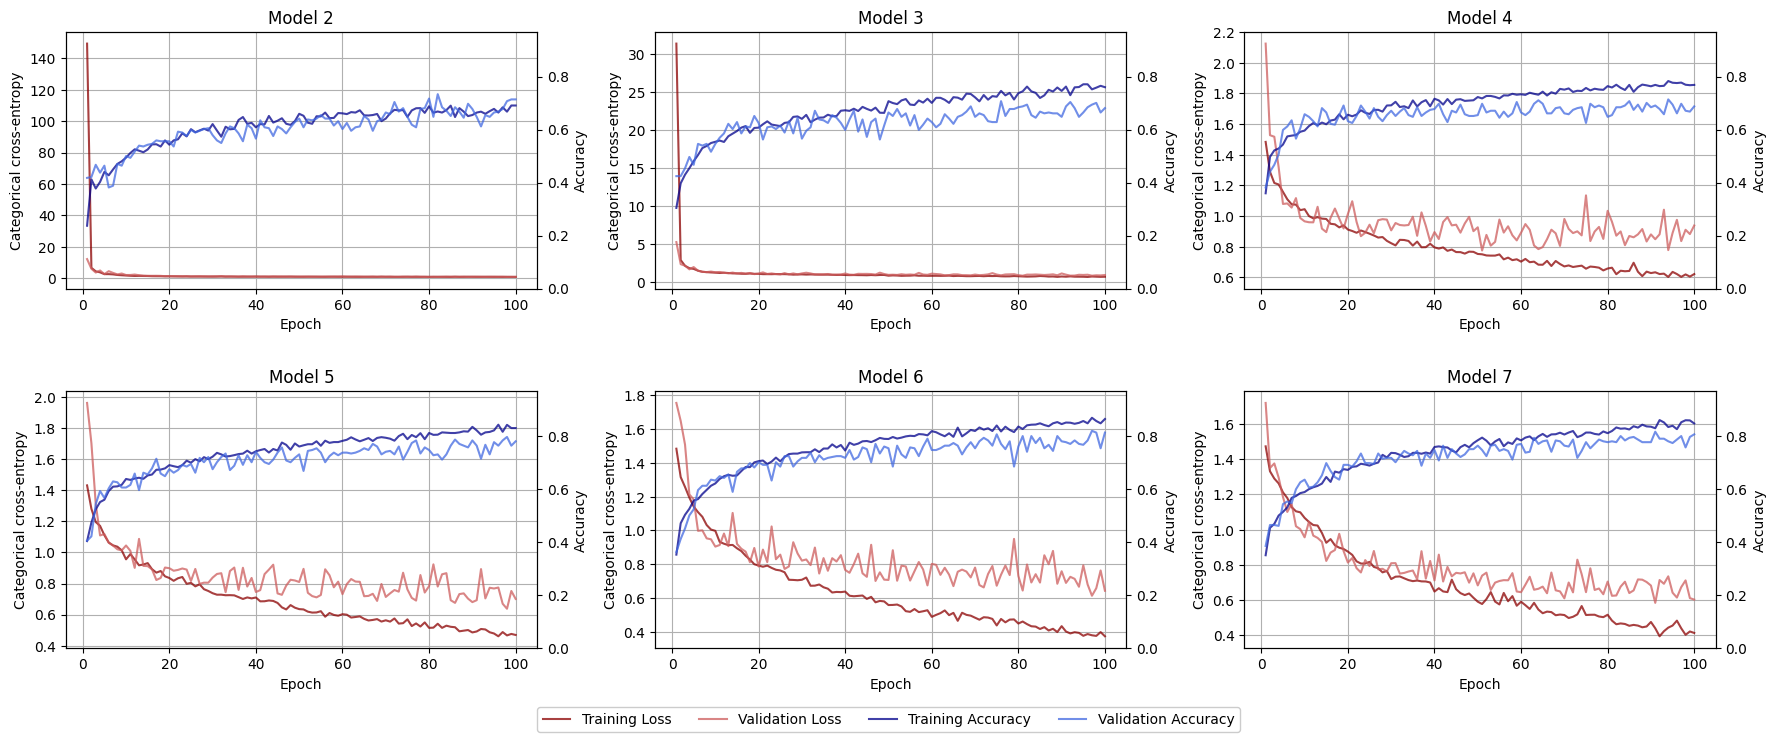

In [ ]:
history_list = [history2, history3, history4, history5, history6, history7]
learning_curves_all(history_list)
